# Многоцелевая модель для NER + event-CLS

Для обучения и оценки модели используется датасет [NEREL](https://huggingface.co/datasets/iluvvatar/NEREL)

#### Структура ноутбука 

1. EDA - загрузка jsonl, обзор, графики, выводы 
2. Парсинг и таргеты - парсеры строкового формата NEREL; сбор примеров (`build_examples_from_nerel`) 
3. Токенизация, выравнивание меток, DataLoader - `tokenize_and_align_labels`, Dataset/Collator 
4. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
5. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
6. Инференс и анализ ошибок - inference pipeline и примеры



##### 1. EDA


In [28]:
import json

train_data = []
with open('data/train.jsonl', 'r') as f:
    for _ in range(200):
        line = f.readline()
        train_data.append(json.loads(line))

In [29]:
import json

def create_freq_dict(filename):
    types = []

    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            types.append(json.loads(line)['type'])

    freq_zeros = [0] * len(types)

    return dict(zip(types, freq_zeros))

ent_freq = create_freq_dict('data/ent_types.jsonl')
rel_freq = create_freq_dict('data/rel_types.jsonl')

In [30]:
import re

pattern = r"\t(.*?)\s"

for line in train_data:
    for ent in line['entities']:
        ent_name = re.search(pattern, ent).group().strip()
        ent_freq[ent_name] += 1
        
    for rel in line['relations']:
        rel_name = re.search(pattern, rel).group().strip()
        rel_freq[rel_name] += 1
        

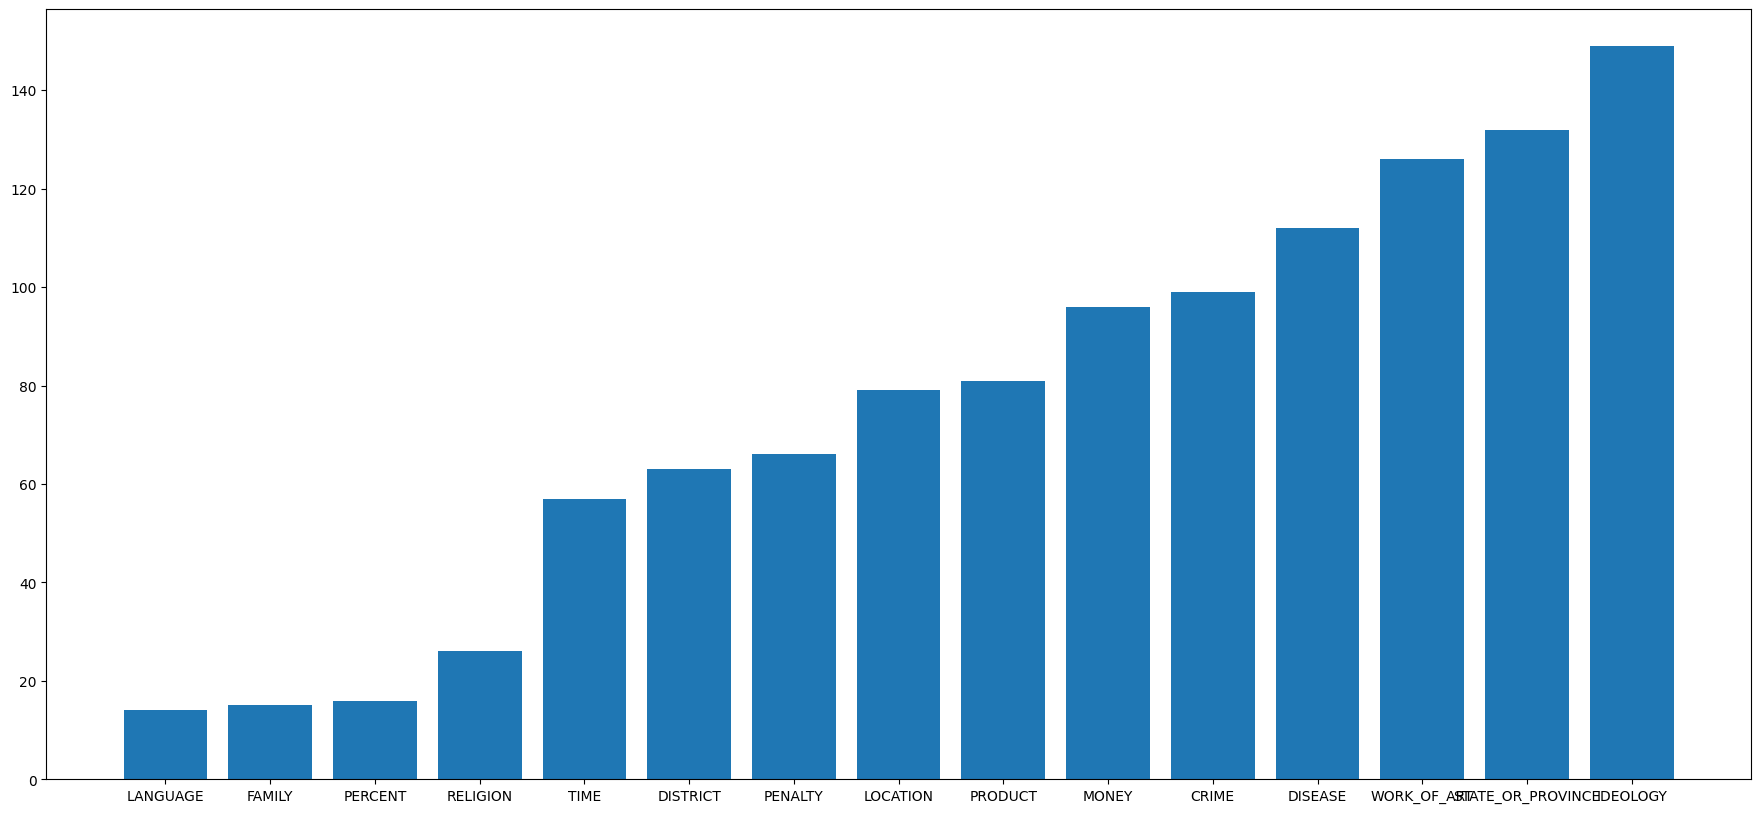

In [31]:
import matplotlib.pyplot as plt

top15_ent, top15_freq = zip(*sorted(ent_freq.items(), key=lambda item: item[1])[:15])

fig = plt.figure(figsize=(22,10))
plt.bar(top15_ent, top15_freq, align='center')

plt.show()

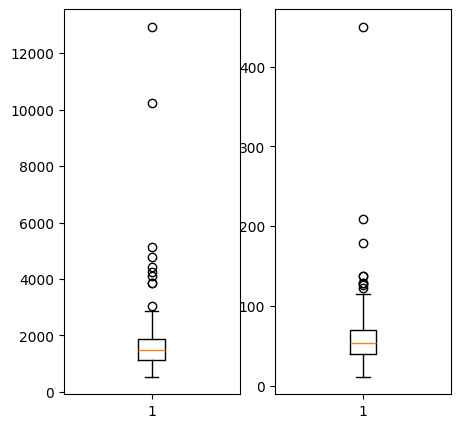

In [32]:
text_lens, entity_count = [], []

for line in train_data:
    text_lens.append(len(line['text']))
    entity_count.append(len(line['entities']))

fig, ax = plt.subplots(1, 2, figsize=(5,5))


ax[0].boxplot(text_lens)
ax[1].boxplot(entity_count)

plt.show()

- Распределение типов сущностей сильно несбалансировано. LANGUAGE, FAMILY и PERCENT встречаются реже всего
- Длина текстов существенно варьируется. Есть выбросы длиной > 6000
- Количество сущностей на документ также несбалансировано


Метрики следует оценивать с учётом дисбаланса классов

##### Парсинг и подготовка таргетов


In [33]:

import re
from collections import Counter

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}


In [34]:
def read_and_parse_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            sample=json.loads(line)
            for i in range(len(sample['entities'])):
                sample['entities'][i] = parse_entity_line(sample['entities'][i])
            for i in range(len(sample['relations'])):
                sample['relations'][i] = parse_relation_line(sample['relations'][i])
            data.append(sample)
    return data

train_data = read_and_parse_jsonl('data/train.jsonl')
test_data = read_and_parse_jsonl('data/test.jsonl')



In [35]:
def make_event_list(records, K=30):
    event_counter = Counter()
    
    for record in records:
        for relation in record['relations']:
            event_counter[relation['type']] += 1
    
    top_k_events = [event_type for event_type, _ in event_counter.most_common(K)]
    
    return top_k_events

In [36]:
from typing import List

def whitespace_tokenize_with_offsets(text: str):
    tokens = []
    spans = []
    for m in re.finditer(r'\S+', text):
        tokens.append(m.group())
        spans.append((m.start(), m.end()))
    return tokens, spans

def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:

    examples = []
    for rec in records:
        text = rec['text']
        tokens, token_spans = whitespace_tokenize_with_offsets(text)
        token_labels = ["O"] * len(tokens)
        
        for ent in rec['entities']:
            base_type = ent['type']
            span_start = ent['start']
            span_stop = ent['end']
            overlaps = []
            for i, (start, end) in enumerate(token_spans):
                if not (end <= span_start or start >= span_stop):
                    overlaps.append(i)
            if not overlaps:
                continue
            
            for j, tok_idx in enumerate(overlaps):
                if token_labels[tok_idx] != "O":
                    continue
                prefix = "B" if j == 0 else "I"
                token_labels[tok_idx] = f"{prefix}-{base_type}"

        cls_vec = [0] * len(event_list)
        for rel in rec['relations']:
            rel_type = rel['type']
            if rel_type in event_list:
                idx = event_list.index(rel_type)
                cls_vec[idx] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "tags": token_labels,
            "cls_vec": cls_vec
        })
        
    return examples

event_list = make_event_list(train_data)
examples = build_examples_from_nerel(train_data, event_list)

test_examples = build_examples_from_nerel(test_data, event_list)

print("Пример tokens/tags:", examples[2]["tokens"][:20], examples[2]["tags"][:20])
print("Пример cls_vec:", examples[2]["cls_vec"])


Пример tokens/tags: ['Россия', 'задерживает', 'поставку', 'генсека', 'Сегодня', 'в', 'Дохе', 'открывается', 'заседание', 'Форума', 'стран-экспортеров', 'газа', '(ФСЭГ),', 'которое', 'должно', 'избрать', 'генсека', 'этой', 'организации.', 'По'] ['B-COUNTRY', 'O', 'O', 'B-PROFESSION', 'B-DATE', 'O', 'B-CITY', 'O', 'B-EVENT', 'B-ORGANIZATION', 'I-ORGANIZATION', 'I-ORGANIZATION', 'B-ORGANIZATION', 'O', 'O', 'O', 'B-PROFESSION', 'O', 'O', 'O']
Пример cls_vec: [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0]


In [38]:
print("Пример tokens/tags:", test_examples[2]["tokens"][:20], test_examples[2]["tags"][:20])
print("Пример cls_vec:", test_examples[2]["cls_vec"])


Пример tokens/tags: ['Умер', 'самый', 'старый', 'миллиардер', 'в', 'мире', 'Дэвид', 'Рокфеллер', 'Дэвид', 'Рокфеллер', '24', 'октября', '1953', 'года', 'В', 'США', 'в', 'возрасте', '101', 'года'] ['B-EVENT', 'O', 'O', 'B-PROFESSION', 'O', 'O', 'B-PERSON', 'I-PERSON', 'B-PERSON', 'I-PERSON', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'B-COUNTRY', 'O', 'O', 'B-AGE', 'I-AGE']
Пример cls_vec: [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0]


##### 3. Токенизация и выравнивание меток

In [ ]:
from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base', use_fast=True)

def tokenize_and_align_labels(examples_batch):
    tokenized = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    labels = []
    for i, word_labels in enumerate(examples_batch["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx == None or word_idx == prev_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(word_labels[word_idx])
            prev_word_idx = word_idx
        labels.append(label_ids)
    tokenized["labels"] = labels
    return tokenized

In [40]:
import torch
from transformers import DataCollatorForTokenClassification

class MultiTaskDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.base_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
    
    def __call__(self, features):
        cls_labels = [f.pop("cls_vec") for f in features]
        
        batch = self.base_collator(features)
        
        batch["cls_labels"] = torch.tensor(cls_labels, dtype=torch.float32)
        
        return batch

In [41]:
from datasets import Dataset, DatasetDict
from torch.utils.data import DataLoader

unique_labels = set()
for ex in examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")
print(unique_labels)
label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

for ex in examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]
    
for ex in test_examples:
    ex["tags"] = [label2id[t] for t in ex["tags"]]

full_ds = Dataset.from_list(examples)
split = full_ds.train_test_split(test_size=0.1, seed=42)
dataset = DatasetDict({"train": split["train"], "test": split["test"]})
test_dataset = Dataset.from_list(test_examples)

tokenized_dataset = full_ds.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "tags"]
)
tokenized_test = test_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "tags"]
)

print(tokenized_dataset)


data_collator = MultiTaskDataCollator(tokenizer=tokenizer)
train_dataloader = DataLoader(dataset=tokenized_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)

{'B-DATE', 'I-PRODUCT', 'I-IDEOLOGY', 'I-WORK_OF_ART', 'B-AGE', 'B-NUMBER', 'B-WORK_OF_ART', 'I-FAMILY', 'B-FAMILY', 'B-IDEOLOGY', 'I-PERCENT', 'B-COUNTRY', 'I-DISEASE', 'I-STATE_OR_PROVINCE', 'I-LAW', 'B-TIME', 'B-MONEY', 'B-RELIGION', 'B-STATE_OR_PROVINCE', 'B-FACILITY', 'B-LOCATION', 'I-LOCATION', 'I-PROFESSION', 'B-EVENT', 'B-DISEASE', 'I-MONEY', 'I-NUMBER', 'O', 'B-PERSON', 'I-CITY', 'B-ORGANIZATION', 'I-PERSON', 'B-NATIONALITY', 'I-PENALTY', 'B-PERCENT', 'I-COUNTRY', 'I-EVENT', 'B-AWARD', 'I-TIME', 'B-LAW', 'I-DISTRICT', 'B-DISTRICT', 'I-CRIME', 'I-FACILITY', 'B-CITY', 'I-AGE', 'I-NATIONALITY', 'I-DATE', 'I-ORDINAL', 'I-ORGANIZATION', 'B-PENALTY', 'B-PROFESSION', 'B-CRIME', 'I-AWARD', 'B-ORDINAL', 'B-PRODUCT', 'B-LANGUAGE'}


Map: 100%|██████████| 93/93 [00:00<00:00, 568.64 examples/s]

Dataset({
    features: ['cls_vec', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 746
})


In [42]:
batch = next(iter(train_dataloader))

print("Shape'ы у батча:")
print(f"input_ids: {batch['input_ids'].shape}")
print(f"labels: {batch['labels'].shape}")
print(f"cls_labels: {batch['cls_labels'].shape}")

Shape'ы у батча:
input_ids: torch.Size([16, 128])
labels: torch.Size([16, 128])
cls_labels: torch.Size([16, 30])


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [43]:
from transformers import AutoModel
import torch.nn as nn

class JointModel(nn.Module):
    def __init__(self, model_name, num_token_labels, num_cls_labels, dropout_prob=0.4):
        super(JointModel, self).__init__()
        
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        
        self.dropout = nn.Dropout(dropout_prob)
        
        self.token_cls = nn.Linear(hidden_size, num_token_labels)
        
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)
        
        self.num_token_labels = num_token_labels
        self.num_cls_labels = num_cls_labels
        
        self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
    
    def forward(self, input_ids, attention_mask, labels=None, cls_labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)
        
        token_logits = self.token_cls(sequence_output)
        
        cls_logits = self.cls_cls(pooled_output)
        
        if labels != None and cls_labels != None:
        
            token_loss_fct = nn.CrossEntropyLoss()
            cls_loss_fct = nn.BCEWithLogitsLoss()
            
            token_loss = token_loss_fct(token_logits.view(-1, self.num_token_labels), labels.view(-1))
            cls_loss = cls_loss_fct(cls_logits, cls_labels)
            
            loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
            loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
            loss = loss_token_term + loss_cls_term
        
        else:
            loss = None
            token_loss = None
            cls_loss = None
        
        
        return {
            'loss': loss,
            'token_loss': token_loss,
            'cls_loss': cls_loss,
            'token_logits': token_logits,
            'cls_logits': cls_logits
        }

In [44]:
num_token_labels = len(label_list)
num_cls_labels = len(event_list)

model = JointModel(
    model_name='FacebookAI/roberta-base',
    num_token_labels=num_token_labels,
    num_cls_labels=num_cls_labels,
    dropout_prob=0.6
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

model.eval()
with torch.no_grad():
    batch.to(device)
    outputs = model(**batch)
    print(f"\nТестовый forward pass:")
    print(f"Loss: {outputs['loss']:.4f}")
    print(f"Token loss: {outputs['token_loss']:.4f}")
    print(f"CLS loss: {outputs['cls_loss']:.4f}")
    print(f"Token logits shape: {outputs['token_logits'].shape}")
    print(f"CLS logits shape: {outputs['cls_logits'].shape}")

Loading weights: 100%|██████████| 197/197 [00:00<00:00, 607.50it/s, Materializing param=encoder.layer.11.output.dense.weight]              
RobertaModel LOAD REPORT from: FacebookAI/roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.



Тестовый forward pass:
Loss: 4.7981
Token loss: 4.1056
CLS loss: 0.6925
Token logits shape: torch.Size([16, 128, 57])
CLS logits shape: torch.Size([16, 30])


##### 5. Training / Validation



In [45]:
import torch
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup


num_epochs = 15
learning_rate = 3e-5


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps=total_steps)

model.train()
for epoch in range(num_epochs):
    total_loss = 0.0
    total_token_loss = 0.0
    total_cls_loss = 0.0
    n_batches = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        model.zero_grad()
        batch.to(device)
        outputs = model(**batch)
        loss = outputs['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
        total_token_loss += outputs['token_loss']
        total_cls_loss += outputs['cls_loss']
        n_batches += 1
    scheduler.step()
    avg_loss = total_loss/n_batches
    avg_token_loss = total_token_loss/n_batches
    avg_cls_loss = total_cls_loss/n_batches

    print(f"Epoch {epoch+1}")
    print(f"avg loss: {avg_loss:.4f}")
    print(f"avg token loss: {avg_token_loss:.4f}")
    print(f"avg cls loss: {avg_cls_loss:.4f}")

Epoch 1: 100%|██████████| 47/47 [00:15<00:00,  3.01it/s]


Epoch 1
avg loss: 3.4164
avg token loss: 2.8247
avg cls loss: 0.5948


Epoch 2: 100%|██████████| 47/47 [00:15<00:00,  2.99it/s]


Epoch 2
avg loss: 2.7872
avg token loss: 2.2855
avg cls loss: 0.5090


Epoch 3: 100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


Epoch 3
avg loss: 2.5617
avg token loss: 2.0716
avg cls loss: 0.5004


Epoch 4: 100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


Epoch 4
avg loss: 2.3899
avg token loss: 1.8993
avg cls loss: 0.5029


Epoch 5: 100%|██████████| 47/47 [00:15<00:00,  2.95it/s]


Epoch 5
avg loss: 2.2512
avg token loss: 1.7631
avg cls loss: 0.5016


Epoch 6: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 6
avg loss: 2.1192
avg token loss: 1.6324
avg cls loss: 0.5010


Epoch 7: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 7
avg loss: 2.0298
avg token loss: 1.5433
avg cls loss: 0.5014


Epoch 8: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 8
avg loss: 1.9243
avg token loss: 1.4389
avg cls loss: 0.5001


Epoch 9: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 9
avg loss: 1.8495
avg token loss: 1.3637
avg cls loss: 0.5006


Epoch 10: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 10
avg loss: 1.7635
avg token loss: 1.2804
avg cls loss: 0.4975


Epoch 11: 100%|██████████| 47/47 [00:16<00:00,  2.91it/s]


Epoch 11
avg loss: 1.6774
avg token loss: 1.1931
avg cls loss: 0.4980


Epoch 12: 100%|██████████| 47/47 [00:16<00:00,  2.91it/s]


Epoch 12
avg loss: 1.6041
avg token loss: 1.1215
avg cls loss: 0.4955


Epoch 13: 100%|██████████| 47/47 [00:16<00:00,  2.91it/s]


Epoch 13
avg loss: 1.5443
avg token loss: 1.0633
avg cls loss: 0.4933


Epoch 14: 100%|██████████| 47/47 [00:16<00:00,  2.91it/s]


Epoch 14
avg loss: 1.4770
avg token loss: 0.9955
avg cls loss: 0.4927


Epoch 15: 100%|██████████| 47/47 [00:16<00:00,  2.90it/s]

Epoch 15
avg loss: 1.4261
avg token loss: 0.9413
avg cls loss: 0.4951


In [46]:
def get_flat_labels_and_preds_from_model(tokenized_split, model, device, max_samples=None):
    y_true = []
    y_pred = []
    for i, ex in enumerate(tokenized_split):
        if max_samples is not None and i >= max_samples:
            break

        input_ids = torch.tensor([ex["input_ids"]], dtype=torch.long).to(device)
        attention_mask = torch.tensor([ex["attention_mask"]], dtype=torch.long).to(device)
        labels = torch.tensor([ex["labels"]], dtype=torch.long).to(device)
        cls_labels = torch.tensor([ex["cls_vec"]], dtype=torch.float32).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels, cls_labels=cls_labels)
            token_logits = outputs['token_logits']
            token_preds = torch.argmax(token_logits, dim=-1).squeeze(0).cpu().tolist()
            cls_logits = outputs['cls_logits']
            cls_preds = (torch.sigmoid(cls_logits) > 0.5).squeeze(0).cpu().tolist()

        true_labels = ex["labels"]

        filtered_true = []
        filtered_pred = []
        for p, t in zip(token_preds, true_labels):
            if t == -100:
                continue
            filtered_true.append(int(t))
            filtered_pred.append(int(p))

        minlen = min(len(filtered_true), len(filtered_pred))
        if minlen == 0:
            continue
        y_true.append(filtered_true[:minlen])
        y_pred.append(filtered_pred[:minlen])
        
        y_true.append(ex['cls_vec'])
        y_pred.append(cls_preds)

    return y_true, y_pred

In [47]:
from sklearn.metrics import f1_score

model.eval()
y_true, y_pred = get_flat_labels_and_preds_from_model(tokenized_test, model, device)

print("F1 tokens:       ", f1_score(y_true[0], y_pred[0], average="macro"))
print("F1 cls:       ", f1_score(y_true[1], y_pred[1], average="micro"))

F1 tokens:        0.7277777777777777
F1 cls:        0.9


Метрики на тесте:
- F1 tokens (macro): 0.728
- F1 cls (micro): 0.900

Модель лучше справляется с document-level классификацией, чем с token-level NER

##### 6. Инференс, квантизация и анализ ошибок

In [48]:
def predict(
    text,
    model,
    tokenizer,
    id2label,
    event_list,
    device,
    max_length
):
    model.eval()

    words = text.split()
    word_offsets = []
    current_pos = 0
    for word in words:
        start = text.find(word, current_pos)
        end = start + len(word)
        word_offsets.append((start, end))
        current_pos = end

    encoding = tokenizer(
        words,
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        token_logits = outputs['token_logits']
        token_preds = torch.argmax(token_logits, dim=-1).squeeze(0).cpu().tolist()

        cls_logits = outputs['cls_logits']
        cls_probs = torch.sigmoid(cls_logits).squeeze(0).cpu().tolist()

    word_ids = encoding.word_ids(batch_index=0)

    bio_tags = []
    filtered_tokens = []
    filtered_offsets = []
    prev_word_idx = None

    for i, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == prev_word_idx:
            prev_word_idx = word_idx
            continue

        filtered_tokens.append(words[word_idx])
        bio_tags.append(id2label[token_preds[i]])
        filtered_offsets.append(word_offsets[word_idx])

        prev_word_idx = word_idx

    cls_probabilities = {
        event_type: prob
        for event_type, prob in zip(event_list, cls_probs)
    }

    predicted_events = [
        event_type
        for event_type, prob in cls_probabilities.items()
        if prob > 0.5
    ]

    return {
        'text': text,
        'tokens': filtered_tokens,
        'bio_tags': bio_tags,
        'offsets': filtered_offsets,
        'cls_probabilities': cls_probabilities,
        'predicted_events': predicted_events
    }

In [49]:
raw_texts = [
    'Премьер-министр Японии Санаэ Такаити рассказала, что, объявив досрочные выборы в нижнюю палату парламента, которые проходят 8 февраля, поставила на кон свой пост главы правительства',
    'С начала реализации программы реновации в Юго-Западном административном округе (ЮЗАО) расселили 100 домов старого жилого фонда. Об этом сообщил заместитель Мэра Москвы по вопросам градостроительной политики и строительства Владимир Ефимов.',
    'В ресторане «Сыроварня» устроят гастроужин по мотивам русских сказок — 12 февраля',
    '8 февраля в России отмечают День российской науки. В этот день в 1724 году была основана Петербургская академия наук. Глава региона Руслан Кухарук поздравил ученых, исследователей, преподавателей и всех, кто посвятил свою жизнь науке, в своем телеграм-канале.',
    'В Тейкове после вмешательства прокуратуры восстановлены права инвалидов на доступную среду. Нарушения были выявлены в ходе проверки исполнения законодательства о доступности объектов социальной инфраструктуры для маломобильных граждан.',
    'Морозы в Новгородской области продлеваются. По прогнозам синоптиков, сегодня, 8 февраля, продолжается усиление влияния скандинавского антициклона: температура воздуха днём — от минус 7 до минус 12 градусов.',
    'Музей геологии нефти и газа в день российской науки превратился в портал в будущее. Здесь жители и гости столицы Югры смогли познакомиться с передовыми технологиями, послушать ученых и узнать больше о физике, нейросетях, механике и экологии.',
    'В столице с 15 по 19 февраля пройдет Неделя фигурного катания. Серия открытых мастер-классов и массовых тренировок позволит любителям этого вида спорта любого уровня и возраста улучшить свои навыки и провести время вместе с чемпионами.'
    ]

In [ ]:
import time

processed_texts = []

start_processing = time.time()
for text in raw_texts:
    prediction = predict(text=text, model=model, tokenizer=tokenizer, id2label=id2label, event_list=event_list, device=device, max_length=128)
    processed_texts.append(prediction)
    
total_time = time.time() - start_processing

In [51]:
def print_pred(pred):
    print('Текст:')
    print(pred['text'])
    print()

    print('Предсказания NER:')

    entities = []
    current_entity = None

    for tag, offset in zip(pred['bio_tags'], pred['offsets']):
        if tag.startswith('B-'):
            if current_entity:
                entities.append(current_entity)
            current_entity = {
                'start': offset[0],
                'end': offset[1],
                'tag': tag[2:]
            }
        elif tag.startswith('I-') and current_entity:
            current_entity['end'] = offset[1]
        elif tag == 'O':
            if current_entity:
                entities.append(current_entity)
                current_entity = None

    if current_entity:
        entities.append(current_entity)

    text = pred['text']
    if entities:
        for entity in entities:
            entity_text = text[entity['start']:entity['end']]
            print(f"{entity_text:<30s} [{entity['tag']}]")
    else:
        print("  (сущности не найдены)")
    print()


    print('Предсказания классификаций:')
    if pred['predicted_events']:
        for event in pred['predicted_events']:
            prob = pred['cls_probabilities'][event]
            print(f"{event:<30s} (вероятность: {prob:.2%})")
    else:
        print("  (не обнаружено)")


In [52]:
print_pred(processed_texts[0])

Текст:
Премьер-министр Японии Санаэ Такаити рассказала, что, объявив досрочные выборы в нижнюю палату парламента, которые проходят 8 февраля, поставила на кон свой пост главы правительства

Предсказания NER:
Премьер-министр Японии         [PROFESSION]
Санаэ Такаити                  [PERSON]
рассказала,                    [EVENT]
выборы                         [EVENT]

Предсказания классификаций:
WORKPLACE                      (вероятность: 77.57%)
ALTERNATIVE_NAME               (вероятность: 95.43%)
WORKS_AS                       (вероятность: 88.91%)
PARTICIPANT_IN                 (вероятность: 86.38%)
POINT_IN_TIME                  (вероятность: 82.59%)
TAKES_PLACE_IN                 (вероятность: 78.55%)
HEADQUARTERED_IN               (вероятность: 69.15%)
ORIGINS_FROM                   (вероятность: 64.80%)
LOCATED_IN                     (вероятность: 62.64%)
AGE_IS                         (вероятность: 65.85%)


In [55]:
print_pred(processed_texts[1])

Текст:
С начала реализации программы реновации в Юго-Западном административном округе (ЮЗАО) расселили 100 домов старого жилого фонда. Об этом сообщил заместитель Мэра Москвы по вопросам градостроительной политики и строительства Владимир Ефимов.

Предсказания NER:
С                              [EVENT]
начала                         [EVENT]
программы                      [PROFESSION]
Юго-Западном административном округе [COUNTRY]
(ЮЗАО)                         [ORGANIZATION]
расселили                      [EVENT]
100 домов                      [DATE]

Предсказания классификаций:
WORKPLACE                      (вероятность: 81.26%)
ALTERNATIVE_NAME               (вероятность: 94.62%)
WORKS_AS                       (вероятность: 87.70%)
PARTICIPANT_IN                 (вероятность: 84.08%)
POINT_IN_TIME                  (вероятность: 75.96%)
TAKES_PLACE_IN                 (вероятность: 75.95%)
HEADQUARTERED_IN               (вероятность: 74.80%)
ORIGINS_FROM                   (вероятност

In [ ]:
model_cpu = model.to('cpu')

quantized_model = torch.quantization.quantize_dynamic(
    model_cpu,
    {torch.nn.Linear},
    dtype=torch.qint8
)

processed_texts_q = []

start_processing = time.time()
for text in raw_texts:
    prediction_q = predict(text=text, model=quantized_model, tokenizer=tokenizer, id2label=id2label, event_list=event_list, device='cpu', max_length=128)
    processed_texts_q.append(prediction_q)
    
total_time_quantized = time.time() - start_processing

model.to(device)

print('Время выполнения предсказаний')
print(f'Время предсказаний до квантования: {total_time:.6f} секунд')
print(f'Время предсказаний после квантования: {total_time_quantized:.6f} секунд')

/tmp/ipykernel_14034/392831510.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


Время выполнения предсказаний
Время предсказаний до квантования: 0.084421 секунд
Время предсказаний после квантования: 0.453191 секунд


In [54]:
from sklearn.metrics import f1_score

quantized_model.eval()
y_true_q, y_pred_q = get_flat_labels_and_preds_from_model(tokenized_test, quantized_model, 'cpu')

print("F1 tokens:       ", f1_score(y_true_q[0], y_pred_q[0], average="macro"))
print("F1 cls:       ", f1_score(y_true_q[1], y_pred_q[1], average="micro"))
print()
print('Разница в точности предсказаний до и после квантования')
print("F1 tokens:       ", abs(f1_score(y_true_q[0], y_pred_q[0], average="macro") - f1_score(y_true[0], y_pred[0], average="macro")))
print("F1 cls:       ", abs(f1_score(y_true_q[1], y_pred_q[1], average="micro") - f1_score(y_true[1], y_pred[1], average="micro")))


F1 tokens:        0.5925925925925926
F1 cls:        0.9

Разница в точности предсказаний до и после квантования
F1 tokens:        0.13518518518518519
F1 cls:        0.0


На примерах выявлены следующие проблемы:
- "программы" определяется как PROFESSION
- "100 домов" определяется как DATE
- Высокие вероятности (60-95%) даже для неочевидных связей


- Квантизация замедлила инференс (0.084s -> 0.453s)
  - Это связано с использованием CPU и небольшим размером батчей
- F1 для NER упал с 0.728 до 0.593